## Generative models

In short, generative models belong to a class of statistical models that are capable of generating new instances based on a dataset. Typically, these models are utilized in unsupervised learning.

Formally, we can think of a dataset as a sequence of instances $x_1, x_2, ..., x_n$ from a data probability distribution $p(x)$. In the example image below, the blue region represents the part of the image space that contains real images with a high probability (above some threshold), while the black dots indicate our data points (each representing an image in our dataset).

<div style="text-align:center;">
    <img src="./images/gm.png" alt="Example Image" style="width:600px;">
</div>
We can define our generative model as a probability distribution with $\theta$ parameters, denoted as $\hat p_{\theta}(x)$. It's important to note that we define this distribution using points from a Gaussian unit. Therefore, we need to find $\theta$ parameters that satisfy our requirements: generating new data $x'$ consistently.

In this context, we will be creating various generative models and exploring both experimentation and theory. Let's begin by discussing the first architecture that we will be constructing.

### Autoencoders

This architecture is very important to us, because autoencoders are a base for some popular generative models. Autoencoders have power to compress data and reconstruct data. Basicaly, this is very interesting because, first application can be compress data and you can spend less memory for any application (yay!). But autoencoder can be much more! Let's check this out and see architecture below:

<!-- ![Example Image](./imgs/autoencoder_architecture.png) -->
<div style="text-align:center;">
    <img src="./images/autoencoder_architecture.png" alt="Example Image" style="width:600px;">
</div>

In here, we can see architecture and loss function that we must to use. This loss is called by "Reconstruction Loss", because when system minimizes this, we can to turn output aproximates by input. 

$$\text{Reconstruction Loss} = \text{MSE}(x, \hat x)$$

Before we in fact construct some generative architecture, lets build an autoencoder and check some theory subjects! Spoiler: You will learn about **latent space** (Latent space is a little bit abstact, think about him like a something in Matrix)

## 1) Import dependencies

In [1]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2) Load Dataset (MNIST)

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
def plot_grid_images(images):
    n_images = len(images)
    fig = plt.figure(figsize=(n_images * 1.5, 2))
    for img_idx in range(n_images):
        plt.subplot(2, n_images, 1 + img_idx)
        plot_image(images[img_idx])

def clip_image(X):
    return np.clip(X, 0., 1.)

def show_reconstructions(model, X, n_images=10):
    reconstructions = model.predict(X[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(clip_image(X[image_index]))
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(clip_image(reconstructions[image_index]))

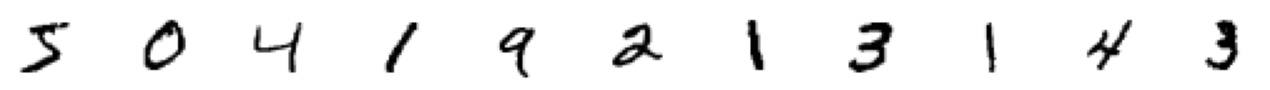

In [6]:
plot_grid_images(X_train_full[:11])

In [7]:
# Preprocessing data
X_train_full, X_test = X_train_full.astype(np.float32) / 255, X_test.astype(np.float32) / 255
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

## 3) Build Architecture using Keras

In [8]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [9]:
codings_size = 16
inputs = tf.keras.layers.Input(shape=[28, 28])
Z = keras.layers.Reshape([28, 28, 1])(inputs)
Z = keras.layers.Conv2D(16, 3, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

# Z = keras.layers.Conv2D(30, 3, padding="same", activation="relu")(Z)
# Z = keras.layers.GlobalAvgPool2D()(Z) # Output 30
Z = keras.layers.Flatten()(Z)
Z = keras.layers.Dense(30, activation='sigmoid')(Z)


codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

In [10]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(7 * 7 * 64)(decoder_inputs)
x = keras.layers.Reshape((7, 7, 64))(x)
x = keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)

x = keras.layers.Conv2DTranspose(16, 3, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)

outputs = keras.layers.Conv2DTranspose(1, 3, padding='same', activation='relu')(x)

# outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [11]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [12]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [13]:
variational_ae.compile(loss="mse", optimizer="adam")
history_vae = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_val, X_val))

Epoch 1/25
430/430 [==============================] - 10s 10ms/step - loss: 0.0519 - val_loss: 0.0452
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0432 - val_loss: 0.0425
Epoch 3/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0410 - val_loss: 0.0398
Epoch 4/25
430/430 [==============================] - 4s 8ms/step - loss: 0.0398 - val_loss: 0.0395
Epoch 5/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0392 - val_loss: 0.0389
Epoch 6/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0387 - val_loss: 0.0383
Epoch 7/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0383 - val_loss: 0.0379
Epoch 8/25
430/430 [==============================] - 4s 9ms/step - loss: 0.0380 - val_loss: 0.0378
Epoch 9/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0378 - val_loss: 0.0374
Epoch 10/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0375 - val_loss: 0.03

1/1 [==============================] - 0s 21ms/step


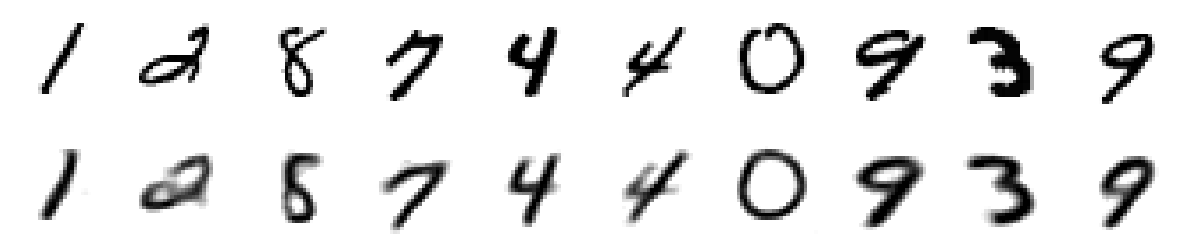

In [16]:
show_reconstructions(variational_ae, X_val)

In [17]:
variational_ae(X_val[:1]).numpy()

array([[[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         

In [13]:
## Another way to train (More configurable form)

def build_model(codings_size=16):

    inputs = tf.keras.layers.Input(shape=[28, 28])
    Z = keras.layers.Reshape([28, 28, 1])(inputs)
    Z = keras.layers.Conv2D(16, 3, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Flatten()(Z)
    Z = keras.layers.Dense(30, activation='sigmoid')(Z)


    codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
    codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = tf.keras.Model(
        inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
    )


    decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
    x = keras.layers.Dense(7 * 7 * 64)(decoder_inputs)
    x = keras.layers.Reshape((7, 7, 64))(x)
    x = keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)

    x = keras.layers.Conv2DTranspose(16, 3, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)

    outputs = keras.layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

    variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

    _, _, codings = variational_encoder([inputs])
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=inputs, outputs=[reconstructions])

    latent_loss = -0.5 * tf.reduce_sum(
        1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
        axis=-1)

    variational_ae.add_loss(tf.reduce_mean(latent_loss) / (28. * 28.))
    
    return variational_encoder, variational_decoder, variational_ae

In [14]:
def plot_losses(history):
    epochs = np.array(list(range(1, len(history['loss_reconstruction']) + 1))) * 10
    
    plt.figure(figsize=(6, 6))
    
    plt.plot(epochs, history['loss_reconstruction'], 'b', label='Loss Reconstruction')
    # plt.plot(epochs, history['loss_sobel'], 'r', label='Loss Sobel')
    plt.plot(epochs, history['loss_dkl'], 'g', label='Loss DKL')
    plt.plot(epochs, history['total_loss'], 'y', label='Total Loss')
    
    plt.title('Training Losses')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.grid(True)
    plt.show()
    
def print_logs(history, epoch, total_epochs, n_batch, step):
    print('------------Losses---------------')
    print('loss_reconstruction: ',  history['loss_reconstruction'][-1])
    # print('loss_sobel: ',  history['loss_sobel'][-1])
    print('loss_dkl: ',  history['loss_dkl'][-1])
    print('total_loss: ',  history['total_loss'][-1])
    print('---------------------------------')
    print(f'Epoch: {epoch}/{total_epochs}')
    print(f'N Batch: {n_batch}')
    print(f'Step: {step}')
    
def plot_multiple_images(images, n_cols=None, k=1):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        clear_output()
        plt.axis("off")

In [15]:
encoder, decoder, variational_ae = build_model()

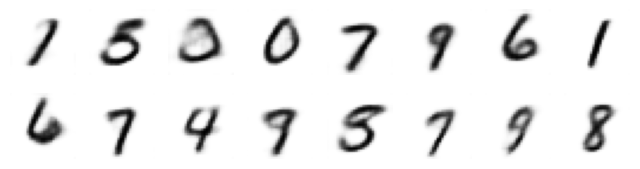

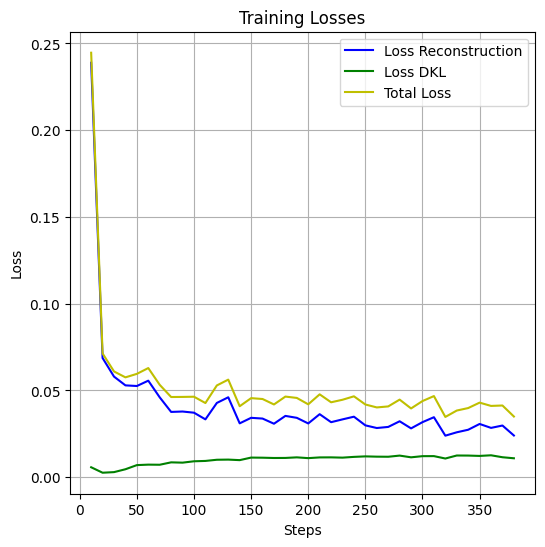

------------Losses---------------
loss_reconstruction:  tf.Tensor(0.024063056, shape=(), dtype=float32)
loss_dkl:  tf.Tensor(0.010938957, shape=(), dtype=float32)
total_loss:  tf.Tensor(0.035002016, shape=(), dtype=float32)
---------------------------------
Epoch: 0/1
N Batch: 3700
Step: 3700


100%|██████████| 1/1 [02:40<00:00, 160.54s/it]


In [53]:
history = {
            'loss_reconstruction': [],
            'loss_sobel': [],
            'loss_dkl': [],
            'total_loss': []
        }

MSE = keras.losses.MeanSquaredError()
# SobelLoss = sobel_loss
optimizer = keras.optimizers.Adam()
total_epochs = 1
step = 0

# Definindo o tamanho do batch
batch_size = 16

# Dividindo o array em batches
batches = [X_train_full[i:i+batch_size] for i in range(0, len(X_train_full), batch_size)]

# Convertendo a lista de batches de volta para um array numpy
batches_array = tf.convert_to_tensor(batches)

for epoch in tqdm(range(total_epochs)):
    n_batch = 0
    for X_batch_1 in batches_array:
        with tf.GradientTape() as tape:
            # Forward pass.
            X_reconstructions = variational_ae(X_batch_1)
            # Loss reconstruction
            loss_reconstruction = MSE(X_batch_1, X_reconstructions)
            # Loss sobel
            # loss_sobel = SobelLoss(X_batch_1, X_reconstructions, gamma=512.0)
            # Add extra loss terms to the loss value.
            loss_total = sum(variational_ae.losses) + loss_reconstruction #+ loss_sobel
        
        gradients = tape.gradient(loss_total, variational_ae.trainable_weights)
        optimizer.apply_gradients(zip(gradients, variational_ae.trainable_weights))
        
        if step % 100 == 0:
            
            history['loss_reconstruction'].append(loss_reconstruction)
            # history['loss_sobel'].append(loss_sobel)
            history['loss_dkl'].append(sum(variational_ae.losses))
            history['total_loss'].append(loss_total)
    
            generated_images = variational_ae(X_batch_1)
            plot_multiple_images(generated_images.numpy(), 8)
            plot_losses(history)
            print_logs(history, epoch, total_epochs, n_batch, step)
            plt.show()
        n_batch += 1
        step += 1


In [16]:
encoder, decoder, variational_ae = build_model()

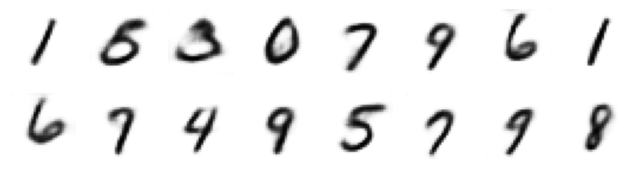

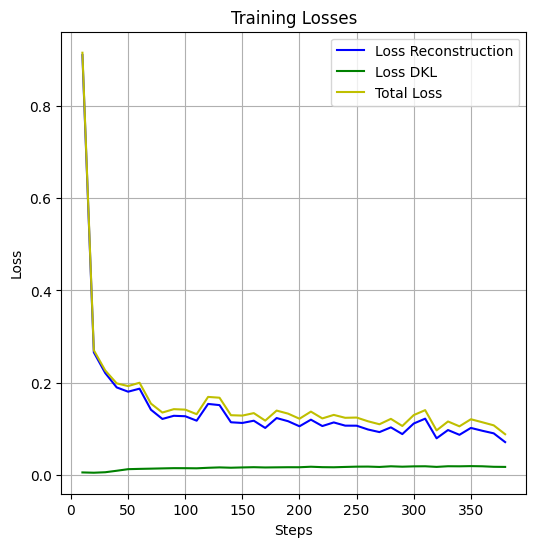

------------Losses---------------
loss_reconstruction:  tf.Tensor(0.07094574, shape=(), dtype=float32)
loss_dkl:  tf.Tensor(0.01710334, shape=(), dtype=float32)
total_loss:  tf.Tensor(0.088049084, shape=(), dtype=float32)
---------------------------------
Epoch: 0/1
N Batch: 3700
Step: 3700


100%|██████████| 1/1 [02:35<00:00, 155.10s/it]


In [32]:
history = {
            'loss_reconstruction': [],
            'loss_sobel': [],
            'loss_dkl': [],
            'total_loss': []
        }

MSE = keras.losses.MeanSquaredError()
# SobelLoss = sobel_loss
optimizer = keras.optimizers.Adam()
total_epochs = 20
step = 0

# Definindo o tamanho do batch
batch_size = 32

# Dividindo o array em batches
batches = [X_train_full[i:i+batch_size] for i in range(0, len(X_train_full), batch_size)]

# Convertendo a lista de batches de volta para um array numpy
batches_array = tf.convert_to_tensor(batches)

for epoch in tqdm(range(total_epochs)):
    n_batch = 0
    for X_batch_1 in batches_array:
        with tf.GradientTape() as tape:
            # Forward pass.
            X_reconstructions = variational_ae(X_batch_1)
            # Loss reconstruction
            X_more_detailed = tf.convert_to_tensor(X_batch_1.numpy() + (X_batch_1.numpy() - X_reconstructions.numpy()[:, :, :, 0]))
            loss_reconstruction = MSE(X_more_detailed, X_reconstructions)
            # Loss sobel
            # loss_sobel = SobelLoss(X_batch_1, X_reconstructions, gamma=512.0)
            # Add extra loss terms to the loss value.
            loss_total = sum(variational_ae.losses) + loss_reconstruction #+ loss_sobel
        
        gradients = tape.gradient(loss_total, variational_ae.trainable_weights)
        optimizer.apply_gradients(zip(gradients, variational_ae.trainable_weights))
        
        if step % 100 == 0:
            
            history['loss_reconstruction'].append(loss_reconstruction)
            # history['loss_sobel'].append(loss_sobel)
            history['loss_dkl'].append(sum(variational_ae.losses))
            history['total_loss'].append(loss_total)
    
            generated_images = variational_ae(X_batch_1)
            plot_multiple_images(generated_images.numpy(), 8)
            plot_losses(history)
            print_logs(history, epoch, total_epochs, n_batch, step)
            plt.show()
        n_batch += 1
        step += 1
